In [ ]:
!nvidia-smi

Wed Aug  3 18:30:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from scipy.ndimage import rotate

import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten
from keras.preprocessing import image
from tensorflow import keras
from keras.models import Sequential

import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import scipy

In [ ]:
import warnings
warnings.simplefilter("ignore")

In [ ]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./225)

AUGMENTED IMAGES

In [ ]:
train_data_gen = data_gen.flow_from_directory(
    '/content/drive/MyDrive/monkey_pox_data/Train',
    shuffle = True,
    color_mode = 'rgb',
    batch_size = 4750,
    target_size = (224, 224),
    class_mode = 'binary',
    seed=None,
    )

val_data_gen = data_gen.flow_from_directory(
    '/content/drive/MyDrive/monkey_pox_data/Val',
    shuffle = True,
    color_mode = 'rgb',
    batch_size = 1073,
    target_size = (224, 224),
    class_mode = 'binary',
    seed=None,
    )

test_data_gen = data_gen.flow_from_directory(
    '/content/drive/MyDrive/monkey_pox_data/Test',
    shuffle = True,
    color_mode = 'rgb',
    batch_size = 45,
    target_size = (224, 224),
    class_mode = 'binary',
    seed=None,
    )

Found 4750 images belonging to 2 classes.
Found 1073 images belonging to 2 classes.
Found 45 images belonging to 2 classes.


In [ ]:
X_train, y_train = train_data_gen.next()
X_test, y_test = test_data_gen.next()
X_val, y_val = val_data_gen.next()

ORIGINAL IMAGES

In [ ]:
Monkeypox = data_gen.flow_from_directory(
    '/content/drive/MyDrive/original_monkey_pox_images',
    color_mode = 'rgb',
    batch_size = 228,
    target_size = (224, 224),
    class_mode = 'binary',
    seed=None,
    )

Found 228 images belonging to 2 classes.


In [ ]:
X, y = Monkeypox.next()

In [ ]:
#zeros = monkey pox
#ones = others

In [ ]:
monkey_pox_0 = np.zeros(shape = (102, 224, 224, 3))
others_0 = np.zeros(shape = (126, 224, 224, 3))

In [ ]:
monkey_pox_i = 0
others_i = 0
for i in range(228):
  if y[i] == 0.:
    monkey_pox_0[monkey_pox_i] = X[i]
    monkey_pox_i += 1
  else:
    others_0[others_i] = X[i]
    others_i += 1

In [ ]:
others_0 = others_0[:102]

In [ ]:
m_0 = np.zeros(shape = (102))
o_0 = np.ones(shape = (102))

In [ ]:
train_m = np.zeros(shape = (70, 224, 224, 3))
train_o = np.zeros(shape = (70, 224, 224, 3))

val_m = np.zeros(shape = (16, 224, 224, 3))
val_o = np.zeros(shape = (16, 224, 224, 3))

test_m = np.zeros(shape = (16, 224, 224, 3))
test_o = np.zeros(shape = (16, 224, 224, 3))

In [ ]:
train_m = monkey_pox_0[:70]
val_m = monkey_pox_0[70:86]
test_m = monkey_pox_0[86:103]

train_o = others_0[:70]
val_o = others_0[70:86]
test_o = others_0[86:103]

In [ ]:
def salt_pepper_noise(img):
    row, col, x = img.shape
    number_of_pixels = random.randint(200, 500)
    for i in range(number_of_pixels):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        img[y_coord][x_coord] = 255

    number_of_pixels = random.randint(200 , 500)
    for i in range(number_of_pixels):
        y_coord=random.randint(0, row - 1)
        x_coord=random.randint(0, col - 1)
        img[y_coord][x_coord] = 0
    return img

def check_size(size):
  return (size, size)

def crop(img, crop_size):
  crop_size = check_size(crop_size)
  r, c, _ = img.shape
  top = np.random.randint(0, r - crop_size[0])
  left = np.random.randint(0, c - crop_size[1])
  bottom = top + crop_size[0]
  right = left + crop_size[1]
  img = img[top:bottom, left:right, :]
  return img

In [ ]:
def augmentation_for_train(data):
  data_90 = np.zeros(shape = (data.shape[0], 224, 224, 3))
  data_180 = np.zeros(shape = (data.shape[0], 224, 224, 3))
  data_270 = np.zeros(shape = (data.shape[0], 224, 224, 3))

  for i in range(data.shape[0]):
    data_90[i] = rotate(data[i], 90)
  for i in range(data.shape[0]):
    data_180[i] = rotate(data_90[i], 90)
  for i in range(data.shape[0]):
    data_270[i] = rotate(data_180[i], 90)

  conc_data = np.concatenate((data, data_90, data_180, data_270))
  random.shuffle(conc_data)

  for i in range(conc_data.shape[0]):
    conc_data[i] = cv2.normalize(conc_data[i], None, alpha=0, beta=1.2, norm_type=cv2.NORM_MINMAX)

  for i in range(conc_data.shape[0]):
    salt_pepper_noise(conc_data[i])

  final_data = np.zeros(shape = (conc_data.shape[0]*10, 224, 224, 3))
  index = 0
  scale_size = 120
  for n in range(10):
    for i in range(conc_data.shape[0]):
      final_data[index] = cv2.resize(crop(conc_data[i], scale_size), (224, 224))
      index += 1
    scale_size += 10

  random.shuffle(final_data)
  return final_data

In [ ]:
def augmentation_for_val(data):
  data_90 = np.zeros(shape = (data.shape[0], 224, 224, 3))
  data_180 = np.zeros(shape = (data.shape[0], 224, 224, 3))
  data_270 = np.zeros(shape = (data.shape[0], 224, 224, 3))

  for i in range(data.shape[0]):
    data_90[i] = rotate(data[i], 90)
  for i in range(data.shape[0]):
    data_180[i] = rotate(data_90[i], 90)
  for i in range(data.shape[0]):
    data_270[i] = rotate(data_180[i], 90)

  conc_data = np.concatenate((data, data_90, data_180, data_270))
  random.shuffle(conc_data)

  final_data = np.zeros(shape = (conc_data.shape[0]*10, 224, 224, 3))
  index = 0
  scale_size = 120
  for n in range(10):
    for i in range(conc_data.shape[0]):
      final_data[index] = cv2.resize(crop(conc_data[i], scale_size), (224, 224))
      index += 1
    scale_size += 10

  random.shuffle(final_data)
  return final_data

In [ ]:
train_m = augmentation_for_train(train_m)

In [ ]:
train_o = augmentation_for_train(train_o)

In [ ]:
val_m = augmentation_for_val(val_m)

In [ ]:
val_o = augmentation_for_val(val_o)

In [ ]:
train_zeros = np.zeros(shape = (1680)) #monkey pox
train_ones = np.ones(shape = (1680)) #other

val_zeros = np.zeros(shape = (384)) #monbkey pox
val_ones = np.zeros(shape = (384)) #other

test_zeros = np.zeros(shape = (16)) #monkey pox
test_ones = np.zeros(shape = (16)) #other

In [ ]:
train_X = np.concatenate((train_m, train_o))
train_y = np.concatenate((train_zeros, train_ones))

val_X = np.concatenate((val_m, val_o))
val_y = np.concatenate((val_zeros, val_ones))

test_X = np.concatenate((test_m, test_o))
test_y = np.concatenate((test_zeros, test_ones))

In [ ]:
def shuffle(x, y):
  temp = list(zip(x, y))
  random.shuffle(temp)
  x, y = zip(*temp)
  x, y = list(x), list(y)
  x = np.array(x)
  y = np.array(y)
  return x, y

In [ ]:
train_X, train_y = shuffle(train_X, train_y)
val_X, val_y = shuffle(val_X, val_y)
test_X, test_y = shuffle(test_X, test_y)

Kaggle Model via https://www.kaggle.com/code/saurabkunwar/monkeypox-detection-95-on-test-dataset


In [ ]:
base_model = tf.keras.applications.EfficientNetB3(include_top=False)

43950080/43941136 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

inputs = keras.layers.Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model(inputs)
dropout_layer_1 = keras.layers.Dropout(0.5)(base_layer)
flat_layer = keras.layers.Flatten()(dropout_layer_1)
dense_1 = keras.layers.Dense(256, activation = "relu")(flat_layer)
dropout_layer_2 = keras.layers.Dropout(0.5)(dense_1)
dense_2 = keras.layers.Dense(128, activation = "relu")(dropout_layer_2)
outputs = keras.layers.Dense(1, activation = "sigmoid")(dense_2)
model = Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

PREVIOUS CODE

In [ ]:
# monkey_pox_90 = np.zeros(shape = (102, 224, 224, 3))
# monkey_pox_180 = np.zeros(shape = (102, 224, 224, 3))
# monkey_pox_270 = np.zeros(shape = (102, 224, 224, 3))

In [ ]:
# for i in range(102):
#   monkey_pox_90[i] = rotate(monkey_pox_0[i], 90)
# for i in range(102):
#   monkey_pox_180[i] = rotate(monkey_pox_90[i], 90)
# for i in range(102):
#   monkey_pox_270[i] = rotate(monkey_pox_180[i], 90)

In [ ]:
# monkey_pox = np.zeros(shape = (408, 224, 224, 3))

In [ ]:
# others_90 = np.zeros(shape = (126, 224, 224, 3))
# others_180 = np.zeros(shape = (126, 224, 224, 3))
# others_270 = np.zeros(shape = (126, 224, 224, 3))

In [ ]:
# for i in range(126):
#   others_90[i] = rotate(others_0[i], 90)

# for i in range(126):
#   others_180[i] = rotate(others_90[i], 90)

# for i in range(126):
#   others_270[i] = rotate(others_180[i], 90)


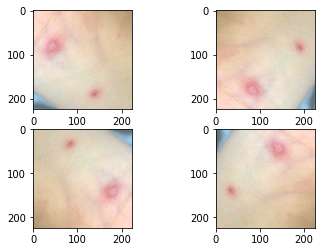

In [ ]:
# f, axarr = plt.subplots(2,2)
# axarr[0,0].imshow(others_0[0])
# axarr[0,1].imshow(others_90[0])
# axarr[1,0].imshow(others_180[0])
# axarr[1,1].imshow(others_270[0])

In [ ]:
# monkey_pox = np.concatenate((monkey_pox_0, monkey_pox_90, monkey_pox_180, monkey_pox_270))
# others = np.concatenate((others_0, others_90, others_180, others_270))

In [ ]:
# random.shuffle(monkey_pox)
# random.shuffle(others)

IMAGE NORMALIZATION

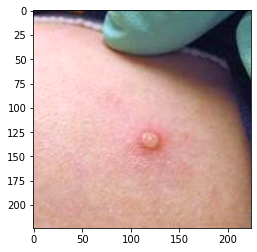

In [ ]:
#Original Image
# plt.imshow(monkey_pox[0])

In [ ]:
# for i in range(408):
#   monkey_pox[i] = cv2.normalize(monkey_pox[i], None, alpha=0, beta=1.2, norm_type=cv2.NORM_MINMAX)

# for i in range(504):
#   others[i] = cv2.normalize(others[i], None, alpha=0, beta=1.2, norm_type=cv2.NORM_MINMAX)


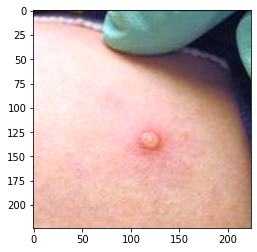

In [ ]:
#Normalized Image
# plt.imshow(monkey_pox[0])

In [ ]:
# def salt_pepper_noise(img):
#     row, col, x = img.shape
#     number_of_pixels = random.randint(200, 500)
#     for i in range(number_of_pixels):
#         y_coord = random.randint(0, row - 1)
#         x_coord = random.randint(0, col - 1)
#         img[y_coord][x_coord] = 255

#     number_of_pixels = random.randint(200 , 500)
#     for i in range(number_of_pixels):
#         y_coord=random.randint(0, row - 1)
#         x_coord=random.randint(0, col - 1)
#         img[y_coord][x_coord] = 0

#     return img

In [ ]:
# for i in range(408):
#   salt_pepper_noise(monkey_pox[i])

# for i in range(504):
#   salt_pepper_noise(others[i])

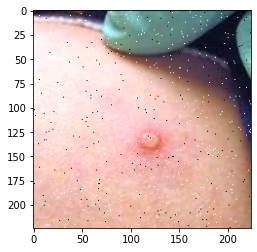

In [ ]:
# plt.imshow(monkey_pox[0])

In [ ]:
# def check_size(size):
#     return (size, size)

# def crop(img, crop_size):
#   crop_size = check_size(crop_size)
#   r, c, _ = img.shape
#   top = np.random.randint(0, r - crop_size[0])
#   left = np.random.randint(0, c - crop_size[1])
#   bottom = top + crop_size[0]
#   right = left + crop_size[1]
#   img = img[top:bottom, left:right, :]
#   return img

In [ ]:
# print(monkey_pox.shape)
# print(others.shape)

(408, 224, 224, 3)
(504, 224, 224, 3)


In [ ]:
# monkey_pox_data = np.zeros(shape = (2040, 224, 224, 3))
# index = 0
# scale_size = 140
# for n in range(5):
#   for i in range(408):
#     monkey_pox_data[index] = cv2.resize(crop(monkey_pox[i], scale_size), (224, 224))
#     index += 1
#   scale_size += 15

# random.shuffle(monkey_pox_data)


In [ ]:
# others_data = np.zeros(shape = (2016, 224, 224, 3))
# index = 0
# scale_size = 140
# for n in range(4):
#   for i in range(504):
#     others_data[index] = cv2.resize(crop(others[i], scale_size), (224, 224))
#     index += 1
#   scale_size += 15

# random.shuffle(others_data)

In [ ]:
# print(monkey_pox_data.shape)
# print(others_data.shape)

(2040, 224, 224, 3)
(2016, 224, 224, 3)
